# Parsing data directly from Google and performing LDA

In [33]:
import warnings
warnings.filterwarnings("ignore")

# !pip install bs4
import urllib.request
from bs4 import BeautifulSoup
query = input("Enter company name ")
query = query.replace(" ","+")
url = "http://www.google.com/search?q="+str(query)
print (url)
req = urllib.request.Request(url, headers={'User-Agent' : "Magic Browser"})
response = urllib.request.urlopen( req )
html = response.read()
soup = BeautifulSoup(html, 'html.parser')
import re
all_links=[]
for link in soup.findAll('a'):
    all_links.append(link.get('href'))
# aspx_links=soup.findAll('a', attrs={'href': re.compile(".aspx")})
# aspx_links = [str(x) for x in aspx_links]
# import re
# links=[]
# for x in aspx_links:
#     m = re.search('https:(.+?)aspx', x)
#     if m:
#         found = m.group(1)
#     links.append(found)
# links= list(set(links))
# final_links = []

Enter company name sara ali khan
http://www.google.com/search?q=sara+ali+khan


In [34]:
print(len(all_links))
all_links[0]

89


'/?sa=X&ved=0ahUKEwjkpoGhw9XkAhWvIbcAHU2TCksQOwgC'

In [35]:
imp_links = []
for x in all_links:
    if x.startswith("/url"):
        imp_links.append(x)

In [36]:
print(len(imp_links))
imp_links[0]

28


'/url?q=https://en.wikipedia.org/wiki/Sara_Ali_Khan&sa=U&ved=2ahUKEwjkpoGhw9XkAhWvIbcAHU2TCksQwW4wAHoECAsQAg&usg=AOvVaw2-TXyLmpn14lv8ZjoRk76g'

In [37]:
final_links = []
for x in imp_links:
    final_links.append("https://google.com"+x)

In [38]:
final_links[0]

'https://google.com/url?q=https://en.wikipedia.org/wiki/Sara_Ali_Khan&sa=U&ved=2ahUKEwjkpoGhw9XkAhWvIbcAHU2TCksQwW4wAHoECAsQAg&usg=AOvVaw2-TXyLmpn14lv8ZjoRk76g'

In [39]:
text=[]
for i in range(len(final_links)):
    req = urllib.request.Request(final_links[i],headers = {'User-Agent' : 'Magic Browser'})
    response = urllib.request.urlopen(req)
    html = response.read()
    soup = BeautifulSoup(html,'lxml')
    for j in range(len(soup.find_all('p'))):
        text.append(soup.find_all('p')[j].get_text())

In [40]:
len(text)

1058

In [41]:
#NLTK for cleaning
from nltk.corpus import stopwords
from string import punctuation
stuff_to_be_removed = list(stopwords.words("english"))+list(punctuation)
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
import nltk
nltk.download('words')
words = set(nltk.corpus.words.words())

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Devyani\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [42]:
def my_tokenizer(s):
    s = s.lower()
    text = nltk.tokenize.word_tokenize(s)
    text = [t for t in text if len(t) > 2]
    text = [lemmatizer.lemmatize(y) for y in text if y not in stuff_to_be_removed]
    text = [t for t in text if not any(c.isdigit() for c in t)]
    
    return text

final_text = [my_tokenizer(s) for s in text]

In [43]:
import gensim
from gensim.corpora import dictionary
from gensim import corpora
from pprint import pprint

id2word = corpora.Dictionary(final_text)
mycorpus = [id2word.doc2bow(s) for s in final_text]
lda_model = gensim.models.ldamodel.LdaModel(corpus=mycorpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [44]:
pprint(lda_model.print_topics())

[(0,
  '0.026*"..." + 0.019*"dance" + 0.012*"since" + 0.011*"child" + 0.010*"every" '
  '+ 0.010*"according" + 0.010*"country" + 0.010*"class" + 0.010*"life" + '
  '0.010*"play"'),
 (1,
  '0.021*"bombay" + 0.019*"century" + 0.013*"island" + 0.010*"..." + '
  '0.009*"marathi" + 0.008*"portuguese" + 0.007*"major" + 0.007*"maharashtra" '
  '+ 0.007*"people" + 0.006*"home"'),
 (2,
  '0.035*"khan" + 0.030*"ali" + 0.020*"sara" + 0.012*"singh" + 0.011*"family" '
  '+ 0.011*"drama" + 0.011*"mother" + 0.010*"industry" + 0.010*"english" + '
  '0.009*"mansoor"'),
 (3,
  '0.024*"one" + 0.018*"share" + 0.011*"latest" + 0.011*"art" + '
  '0.010*"pageviews" + 0.008*"picture" + 0.008*"instant" + 0.008*"topic" + '
  '0.008*"like" + 0.007*"instagram"'),
 (4,
  '0.037*"film" + 0.034*"khan" + 0.013*"sara" + 0.010*"ali" + 0.009*"role" + '
  '0.008*"played" + 0.008*"kapoor" + 0.008*"two" + 0.007*"love" + '
  '0.007*"actor"'),
 (5,
  '0.048*"mumbai" + 0.030*"city" + 0.024*"india" + 0.017*"saraalikhan" + '
  

In [45]:
doc_lda = lda_model[mycorpus]

In [48]:
print('\nPerplexity: ', lda_model.log_perplexity(mycorpus)) 
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=final_text, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.202382157593384

Coherence Score:  0.5400018693964233


In [49]:
import os
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, mycorpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.244830 -0.093945       1        1  32.202148
5      0.187234 -0.281577       2        1  23.073109
1      0.126436  0.151404       3        1  13.830893
2     -0.150318 -0.035424       4        1  11.581573
6      0.018327  0.079777       5        1   5.683001
0      0.010813  0.061079       6        1   4.975918
3      0.028223  0.065159       7        1   4.781489
7      0.024115  0.053527       8        1   3.871873, topic_info=     Category        Freq           Term       Total  loglift  logprob
term                                                                  
59    Default  228.000000         mumbai  228.000000  30.0000  30.0000
24    Default  288.000000           khan  288.000000  29.0000  29.0000
16    Default  238.000000           film  238.000000  28.0000  28.0000
296   Default  133.000000           city  133.000000  27.0000  27.0000
3     Default  129.000000            ali  129.000000  26.0000  26.0000
120   Default  111.000000          india  111.000000  25.0000  25.0000
34    Default  128.000000           sara  128.000000  24.0000  24.0000
670   Default   69.000000            ...   69.000000  23.0000  23.0000
2345  Default   71.000000         bombay   71.000000  22.0000  22.0000
1174  Default   73.000000    saraalikhan   73.000000  21.0000  21.0000
3670  Default   49.000000        century   49.000000  20.0000  20.0000
22    Default   69.000000         indian   69.000000  19.0000  19.0000
479   Default   21.000000            one   21.000000  18.0000  18.0000
3682  Default   35.000000         island   35.000000  17.0000  17.0000
38    Default   69.000000          singh   69.000000  16.0000  16.0000
142   Default   43.000000           year   43.000000  15.0000  15.0000
803   Default   19.000000      bollywood   19.000000  14.0000  14.0000
518   Default   18.000000          dance   18.000000  13.0000  13.0000
197   Default   50.000000           love   50.000000  12.0000  12.0000
102   Default   17.000000          share   17.000000  11.0000  11.0000
224   Default   53.000000           role   53.000000  10.0000  10.0000
474   Default   18.000000           post   18.000000   9.0000   9.0000
14    Default   24.000000         family   24.000000   8.0000   8.0000
209   Default   52.000000         played   52.000000   7.0000   7.0000
286   Default   24.000000          drama   24.000000   6.0000   6.0000
1191  Default   50.000000            two   50.000000   5.0000   5.0000
58    Default   23.000000         mother   23.000000   4.0000   4.0000
374   Default   16.000000           team   16.000000   3.0000   3.0000
1     Default   59.000000          actor   59.000000   2.0000   2.0000
1481  Default   24.000000        marathi   24.000000   1.0000   1.0000
...       ...         ...            ...         ...      ...      ...
5470   Topic8    4.655233        copying    5.291327   3.1234  -5.0599
548    Topic8    4.349851         energy    4.990016   3.1141  -5.1278
1703   Topic8    3.806191            में    4.442021   3.0970  -5.2613
1506   Topic8    3.600807      christian    4.240503   3.0879  -5.3168
1345   Topic8    3.474075          crore    4.110833   3.0831  -5.3526
5280   Topic8    3.398321            app    4.034401   3.0799  -5.3746
5364   Topic8    3.398003           fact    4.034217   3.0798  -5.3747
488    Topic8    3.150391         social    3.791041   3.0663  -5.4504
1863   Topic8    3.125556            खान    3.761386   3.0663  -5.4583
736    Topic8    2.993738          arjun    3.633004   3.0579  -5.5014
1727   Topic8    2.956970            हैं    3.592800   3.0567  -5.5138
1853   Topic8    2.743126            अली    3.378956   3.0430  -5.5888
989    Topic8    2.540853     everything    3.177235   3.0279  -5.6654
1663   Topic8    2.490101           अपनी    3.125932   3.0240  -5.6856
5477   Topic8    2.358153        content    2.994252   3.0126  -5.7400
5475   To

In [50]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=mycorpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [54]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=mycorpus, texts=final_text, start=2, limit=40, step=6)

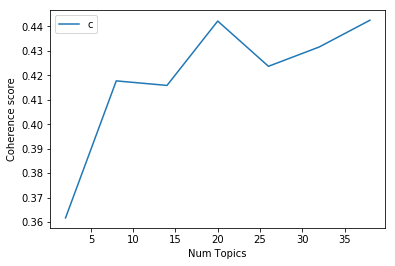

In [55]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [56]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3617
Num Topics = 8  has Coherence Value of 0.4177
Num Topics = 14  has Coherence Value of 0.4158
Num Topics = 20  has Coherence Value of 0.4421
Num Topics = 26  has Coherence Value of 0.4236
Num Topics = 32  has Coherence Value of 0.4315
Num Topics = 38  has Coherence Value of 0.4425


In [57]:
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.023*"mumbai" + 0.016*"film" + 0.010*"city" + 0.010*"khan" + '
  '0.006*"island" + 0.005*"also" + 0.004*"india" + 0.004*"million" + '
  '0.003*"played" + 0.003*"ali"'),
 (1,
  '0.015*"mumbai" + 0.013*"film" + 0.013*"india" + 0.012*"khan" + 0.009*"city" '
  '+ 0.007*"सितंबर" + 0.006*"indian" + 0.006*"national" + 0.005*"role" + '
  '0.004*"..."'),
 (2,
  '0.011*"film" + 0.010*"khan" + 0.007*"india" + 0.006*"indian" + '
  '0.006*"mumbai" + 0.006*"city" + 0.005*"million" + 0.005*"actor" + '
  '0.005*"university" + 0.004*"sara"'),
 (3,
  '0.014*"trailer" + 0.013*"official" + 0.012*"khan" + 0.009*"film" + '
  '0.008*"ali" + 0.007*"sara" + 0.006*"..." + 0.005*"school" + 0.005*"actress" '
  '+ 0.004*"actor"'),
 (4,
  '0.017*"khan" + 0.016*"mumbai" + 0.010*"film" + 0.009*"singh" + '
  '0.007*"india" + 0.007*"best" + 0.006*"..." + 0.005*"ali" + 0.005*"year" + '
  '0.005*"sara"'),
 (5,
  '0.012*"mumbai" + 0.012*"india" + 0.009*"..." + 0.007*"portuguese" + '
  '0.007*"film" + 0.007*"khan"

In [60]:
import pandas as pd
def format_topics_sentences(ldamodel=lda_model, corpus=mycorpus, texts=text):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=mycorpus, texts=final_text)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.0714,"mumbai, film, city, khan, island, also, india,...",[]
1,1,3.0,0.8093,"trailer, official, khan, film, ali, sara, ...,...","[sara, ali, khan, pronounced, saːɾaː, əˈli, ˈx..."
2,2,11.0,0.9845,"khan, ali, film, sara, singh, son, saif, ..., ...","[sara, ali, khan, born, august, mumbai, saif, ..."
3,3,12.0,0.9825,"khan, ali, city, sara, film, saif, also, ..., ...","[khan, four-year-old, acted, advertisement, ac..."
4,4,1.0,0.9794,"mumbai, film, india, khan, city, सितंबर, india...","[teenager, khan, struggled, weight, undergo, d..."
5,5,9.0,0.9930,"film, mumbai, bombay, khan, city, ..., million...","[khan, debut, came, abhishek, kapoor-directed,..."
6,6,9.0,0.9587,"film, mumbai, bombay, khan, city, ..., million...","[week, release, kedarnath, khan, starred, rohi..."
7,7,12.0,0.9629,"khan, ali, city, sara, film, saif, also, ..., ...","[khan, next, committed, star, alongside, karti..."
8,8,0.0,0.0714,"mumbai, film, city, khan, island, also, india,...",[]
9,9,3.0,0.8093,"trailer, official, khan, film, ali, sara, ...,...","[sara, ali, khan, pronounced, saːɾaː, əˈli, ˈx..."


In [61]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9914,"mumbai, film, city, khan, island, also, india, million, played, ali","[attempt, avoid, typecasting, broaden, range, actor, khan, starred, karan, singh, rathod, thrill..."
1,1.0,0.9898,"mumbai, film, india, khan, city, सितंबर, indian, national, role, ...","[following, brief, appearance, comedy, dolly, doli, appeared, alongside, katrina, kaif, kabir, k..."
2,2.0,0.9936,"film, khan, india, indian, mumbai, city, million, actor, university, sara","[following, year, khan, collaborated, deepika, padukone, fourth, time, alongside, anil, kapoor, ..."
3,3.0,0.9888,"trailer, official, khan, film, ali, sara, ..., school, actress, actor","[architecture, city, blend, gothic, revival, indo-saracenic, art, deco, contemporary, style, bui..."
4,4.0,0.9913,"khan, mumbai, film, singh, india, best, ..., ali, year, sara","[mumbai, bus, service, carried, million, passenger, per, day, dropped, million, public, bus, run..."
5,5.0,0.9931,"mumbai, india, ..., portuguese, film, khan, century, bombay, sara, city","[portuguese, actively, involved, foundation, growth, roman, catholic, religious, order, bombay, ..."
6,6.0,0.9863,"film, khan, सितंबर, mumbai, ..., actor, indian, singh, year, release","[indian, badminton, league, ibl, known, premier, badminton, league, also, visiting, mumbai, sinc..."
7,7.0,0.9911,"khan, film, ali, india, sara, movie, mumbai, ..., kapoor, story","[series, poorly, received, film, continued, next, release, black, comedy, kaalakaandi, directed,..."
8,8.0,0.9943,"khan, century, film, ..., trailer, city, mumbai, official, get, sara","[mukku, taken, home, family, move, wedding, nevertheless, keep, insisting, mansoor, come, muslim..."
9,9.0,0.9930,"film, mumbai, bombay, khan, city, ..., million, first, hindi, also","[khan, debut, came, abhishek, kapoor-directed, inter-faith, romance, kedarnath, played, hindu, g..."


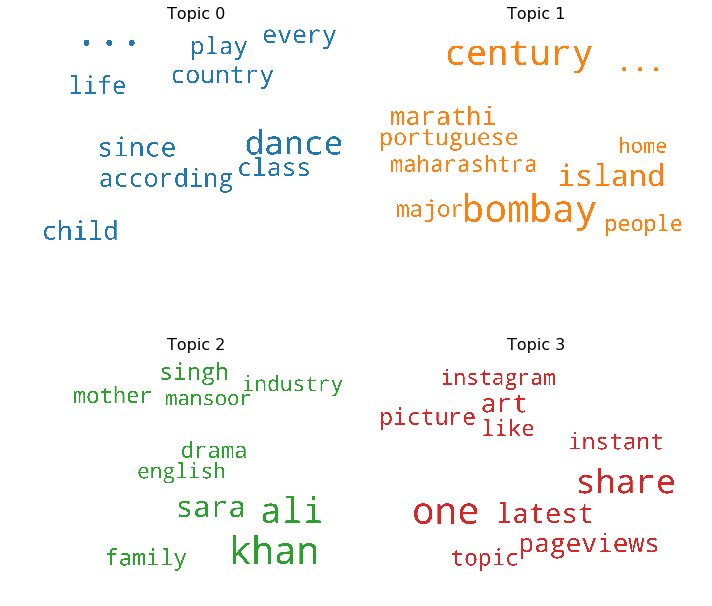

In [63]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stuff_to_be_removed,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

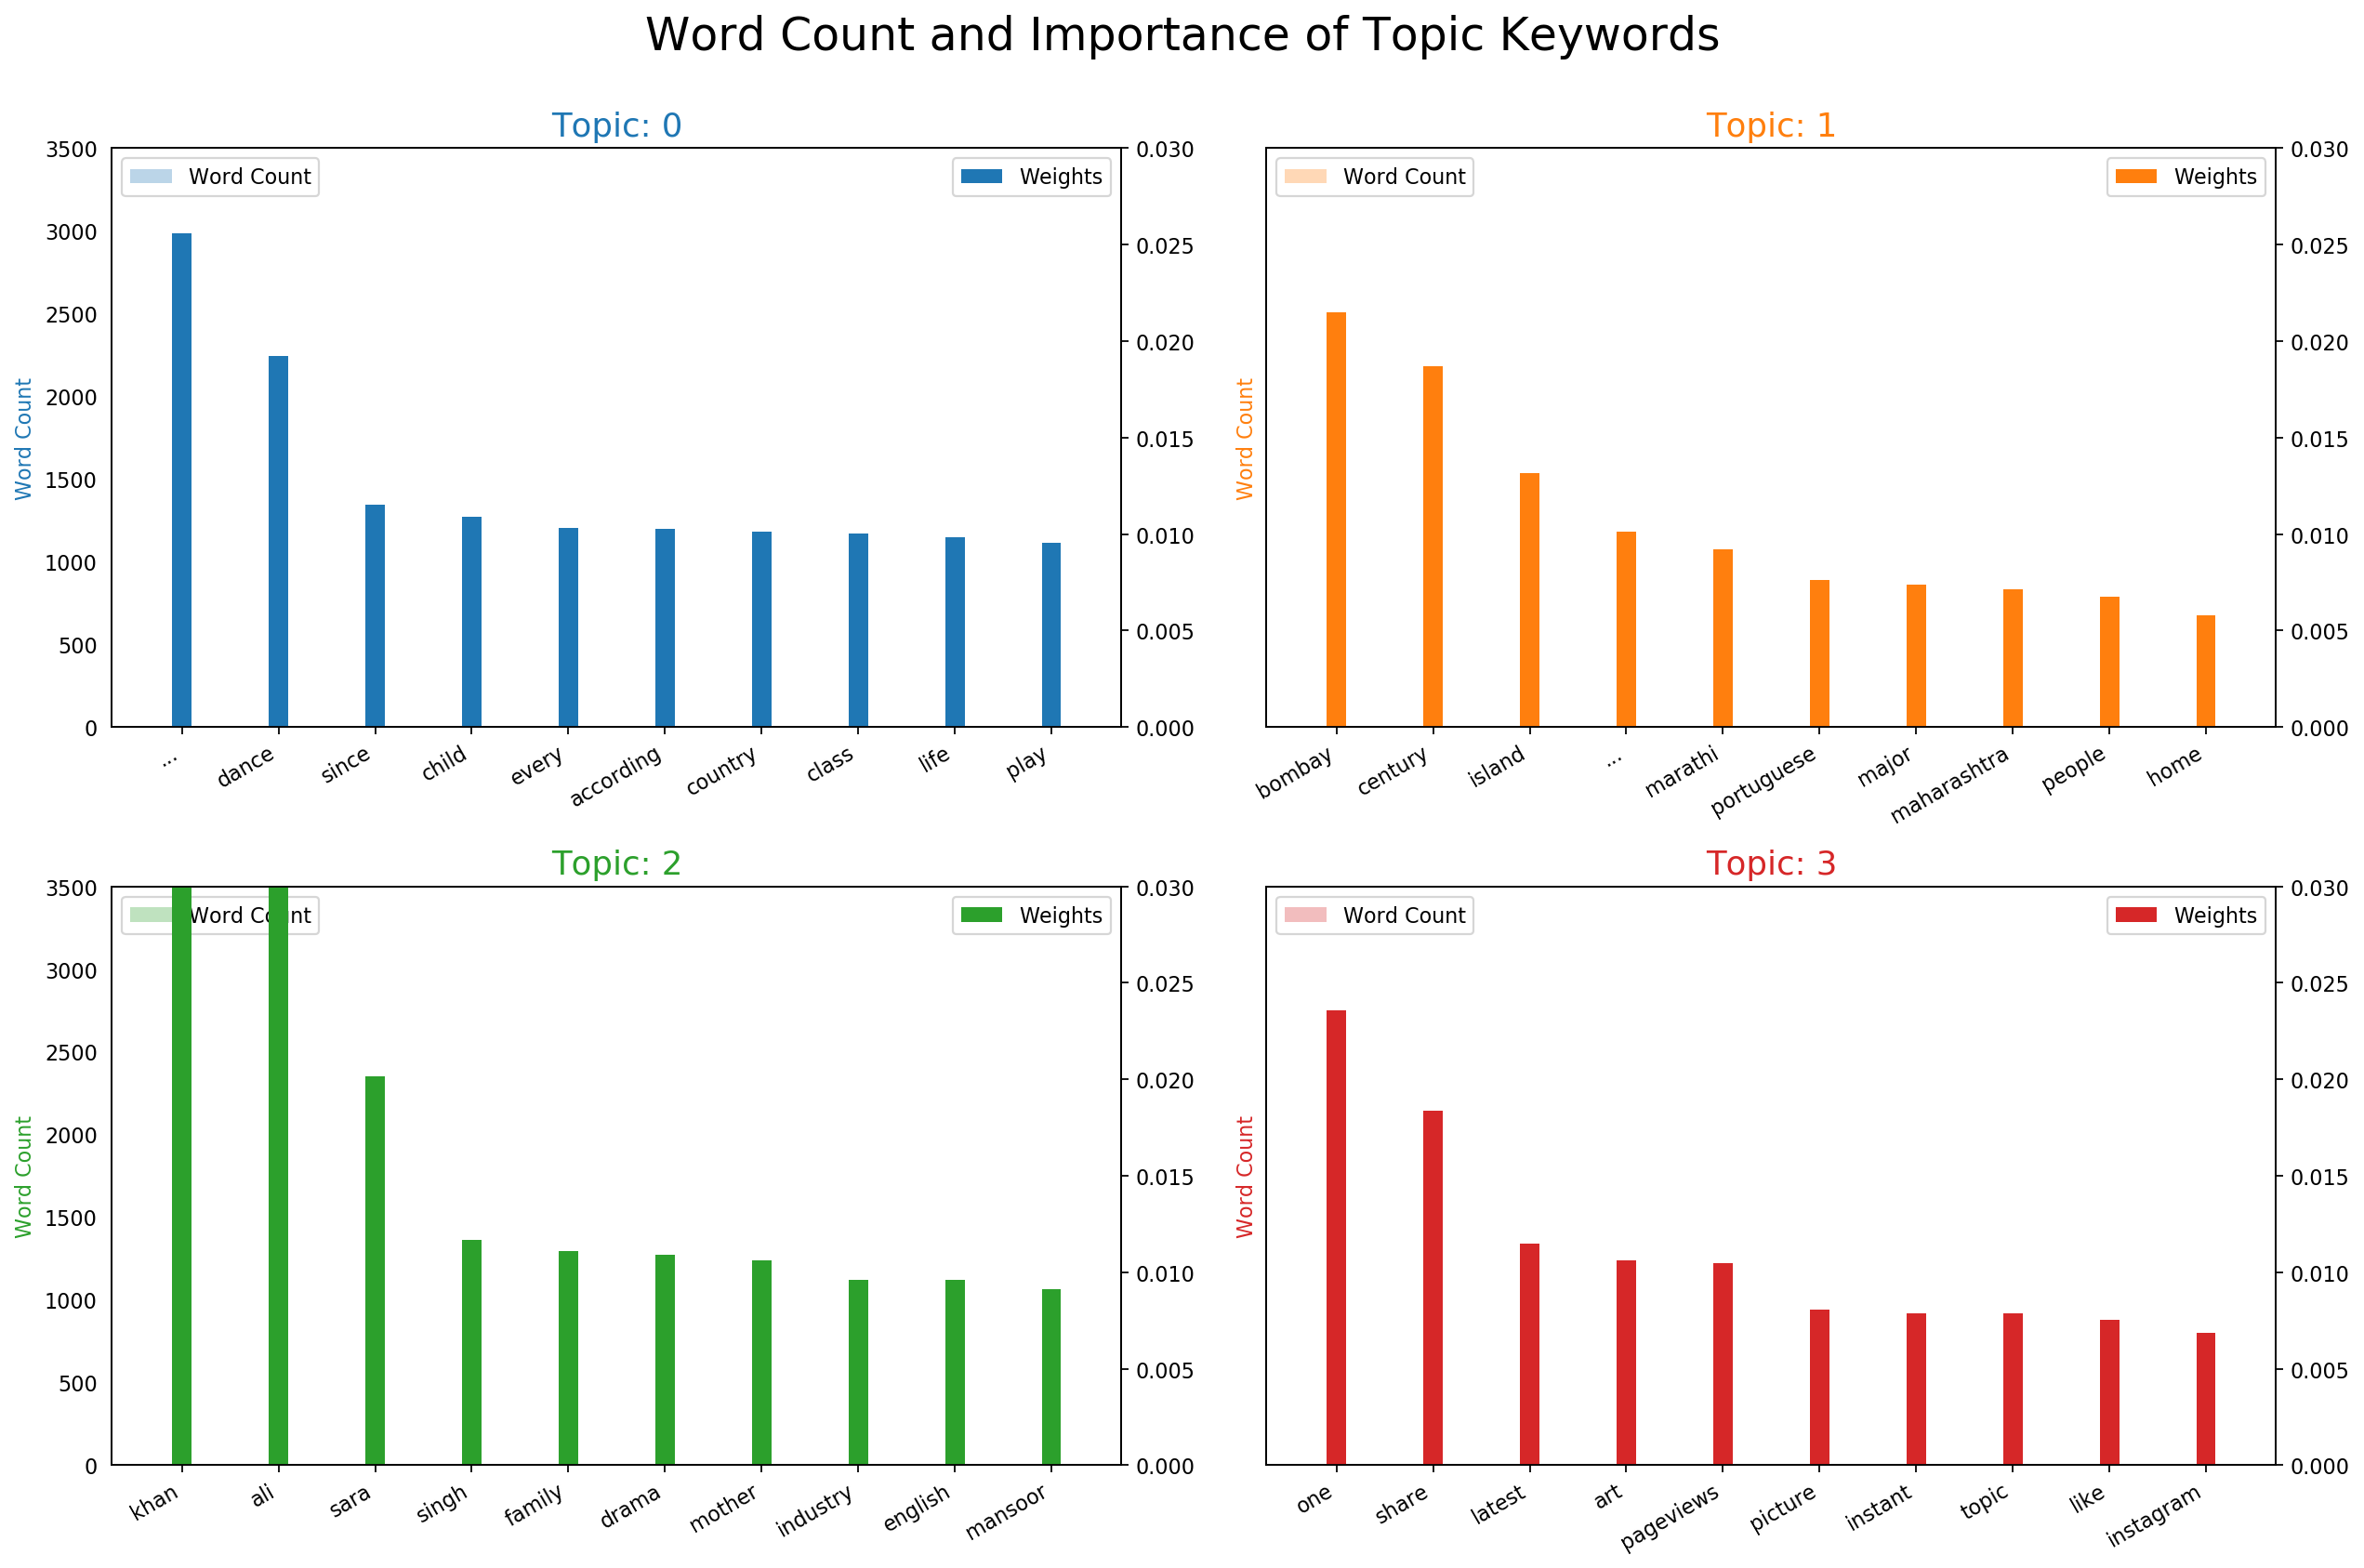

In [64]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in text for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()